In [171]:
import os
import numpy as np
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et
import rasterio
from rasterio.enums import Resampling
import matplotlib.pylab as plt
import pandas as pd

In [172]:
# # Get data and set working directory
project_dir = "/Users/octavia/Dropbox/fire/"

	0 - Rock and water
	1 - Conifer-dominated
	2 - Shrub-dominated
	3 - Sparse meadow
	4 - Dense meadow
	5 - Aspen

In [173]:
df_soil = pd.read_csv('/Users/octavia/Dropbox/fire/fire_data/RF_soil_regrid/vwcJun12utm11.csv', 
                 sep = " ", header = None)
df_soil.columns = ["x", "y", "z"]


In [26]:
df_veg = pd.read_csv("/Users/octavia/Dropbox/fire/fire_data/Veg_regrid/veg12_30m_icb.csv", 
                  sep = " ", header = None)
df_veg.columns = ["x", "y", "z"]


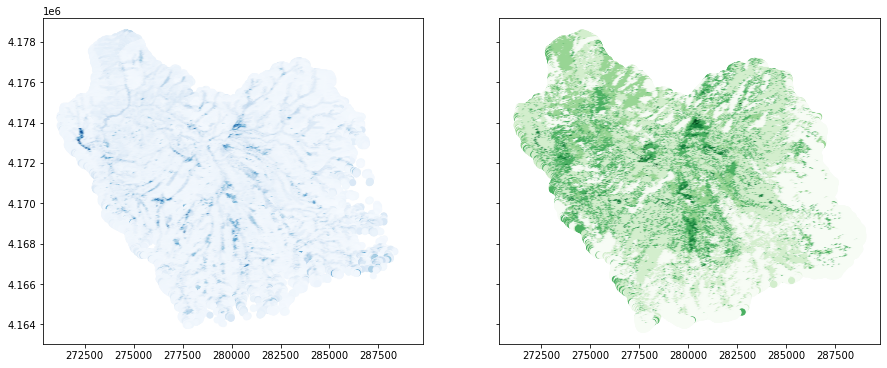

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharey = True, sharex = True)

df = df_soil.copy()
df = df[df.z >= 0]

df2 = df_veg.copy()
df2 = df2[df2.z >= 0]

axes[0].scatter(df.x, df.y,c = df.z, cmap = "Blues")
axes[1].scatter(df2.x, df2.y, c = df2.z, cmap = "Greens")

In [28]:
x = np.arange(max(df_soil.x.min(), df_veg.x.min()), min(df_soil.x.max(), df_veg.x.max()), 30)
y = np.arange(max(df_soil.y.min(), df_veg.y.min()), min(df_soil.y.max(), df_veg.y.max()), 30)
grid_x, grid_y = np.meshgrid(x,y)

In [29]:
soil_points = np.array((list(df_soil.x.ravel()), list(df_soil.y.ravel()))).T
soil_values = np.array(df_soil.z)

In [30]:
veg_points = np.array((list(df_veg.x.ravel()), list(df_veg.y.ravel()))).T
veg_values = np.array(df_veg.z)

In [31]:
from scipy.interpolate import griddata
grid_soil = griddata(soil_points, soil_values, (grid_x, grid_y), method='nearest')
grid_veg = griddata(veg_points, veg_values, (grid_x, grid_y), method='nearest')
# grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')


In [32]:
grid_veg = grid_veg.astype("float")

In [33]:
grid_veg[grid_veg < 0] = np.nan
grid_soil[grid_soil < 0] = np.nan

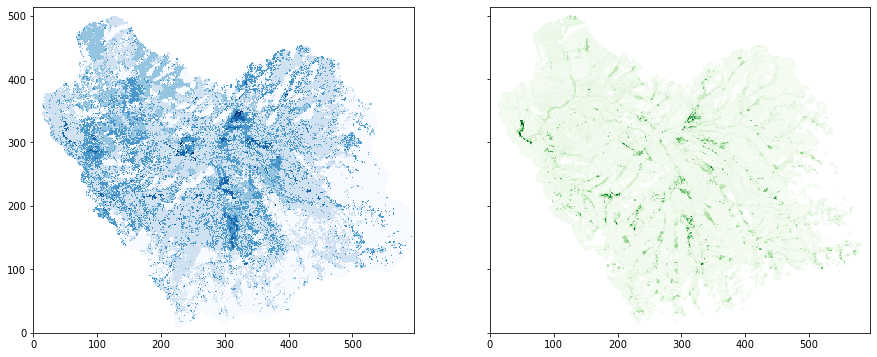

In [34]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharey = True, sharex = True)

df = df_soil.copy()
df = df[df.z >= 0]

df2 = df_veg.copy()
df2 = df2[df2.z >= 0]

axes[0].pcolormesh(grid_veg, cmap = "Blues")
axes[1].pcolormesh(grid_soil, cmap = "Greens")


[Text(0, 0, 'Rock'),
 Text(0, 0, 'Conifer'),
 Text(0, 0, 'Shrub'),
 Text(0, 0, 'grassland'),
 Text(0, 0, 'wetland'),
 Text(0, 0, 'aspen')]

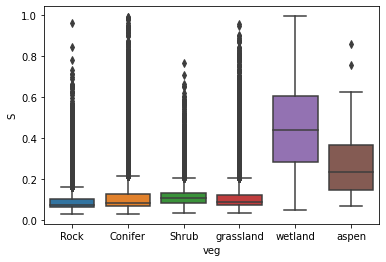

In [151]:
zipped = np.array(( 
        list(grid_x.ravel()), 
        list(grid_y.ravel()),
        list(grid_veg.ravel()), 
        list(grid_soil.ravel())))
inds = np.where((np.isnan(zipped[0] ) ==0) & (np.isnan(zipped[1] ) ==0))
soil_points = zipped[0, inds]
veg_points = zipped[1, inds]


import seaborn as sns

df = pd.DataFrame(zipped.T[inds], columns=["x", "y", "veg", "soil_moisture"])
df["S"] = df["soil_moisture"]/0.4/100.
df = df[df["S"] < 1]

ax = sns.boxplot(x="veg", y="S", data=df)
# ax.set_ylim(0, 10)
xlabels = ["Rock", "Conifer", "Shrub", "grassland", "wetland", "aspen"]

ax.set_xticklabels(xlabels )

In [152]:
df[df.veg == 1]["soil_moisture"].mean()

4.54220968808207

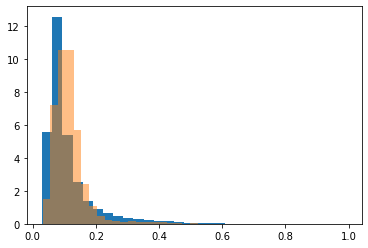

In [153]:
df = df.dropna(axis = 0)
plt.hist(df[df.veg == 1]["S"], 30, density=1);

# len(df[df.veg == 2]["theta"])
plt.hist(df[df.veg == 2]["S"], 30, density = 1, alpha = 0.5);


In [154]:
IC = df[(df.veg>0)& (df.veg<3)][["veg", "S"]].sample(100)

In [155]:
model_dir = "/Users/octavia/Dropbox/fire/fire_model/"

IC_csv = os.path.join(model_dir, "IC.csv")
IC.to_csv(IC_csv, index = False)

In [156]:
IC = np.array(pd.read_csv(IC_csv))

In [158]:
IC[:10]

array([[2.        , 0.17252   ],
       [1.        , 0.0589175 ],
       [1.        , 0.10044975],
       [1.        , 0.061497  ],
       [1.        , 0.36254   ],
       [1.        , 0.1066485 ],
       [1.        , 0.08244825],
       [1.        , 0.06625325],
       [2.        , 0.0820135 ],
       [1.        , 0.1224685 ]])

In [175]:
severity_dir = "/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip"


In [187]:
csvs = [f for f in os.listdir(severity_dir) if "csv" in f]
severities = []
y_min = np.inf
y_max = 0
for csv in csvs:
    path = os.path.join(severity_dir, csv)
    dum = np.array(pd.read_csv(path, sep = " ", header = None)[2])

    x = np.array(pd.read_csv(path, sep = " ", header = None)[0])
    x_min = min(np.min(x), x_min)
    x_max = max(np.max(x), x_max)  
    
    y = np.array(pd.read_csv(path, sep = " ", header = None)[1])
    y_min = min(np.min(y), y_min)
    y_max = max(np.max(y), y_max)      

    dum = list(dum[dum < 1000] )
    severities.append(dum)

severities = [s for slist in severities for s in slist]


In [189]:
x_max - x_min

11997.896999999939

In [190]:
len(severities)

97135

242.30338189118237

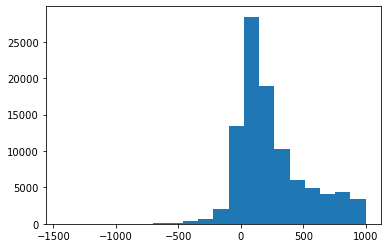

In [186]:
plt.hist(severities, 20)
np.mean(severities)

In [182]:
severities = (np.array(severities) - np.min(severities))/(np.max(severities) - np.min(severities))

0.689369204388827

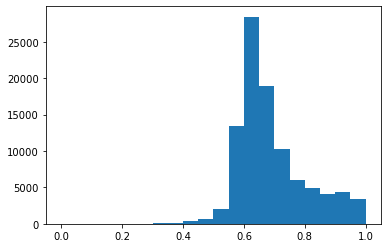

In [183]:
plt.hist(severities, 20)
np.mean(severities)

In [142]:
IC.to_csv("IC.csv", index = False)

In [163]:
model_dir ="/Users/octavia/Dropbox/fire/fire_model/"
severity_csv = os.path.join(model_dir, "severity.csv")
np.savetxt(severity_csv, severities)

In [164]:
severity_dir =os.path.join(model_dir, "severity.csv")
severities = np.loadtxt(severity_dir)

In [165]:
 {'veg': IC[:, 0], 'S': IC[:, 1]}

{'veg': array([2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 2.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2., 1., 1., 1., 2.,
        2., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'S': array([0.17252   , 0.0589175 , 0.10044975, 0.061497  , 0.36254   ,
        0.1066485 , 0.08244825, 0.06625325, 0.0820135 , 0.1224685 ,
        0.0612975 , 0.20061575, 0.07774375, 0.10208525, 0.18265875,
        0.3338225 , 0.14309725, 0.04462225, 0.0953755 , 0.05954425,
        0.0711125 , 0.210673  , 0.0653385 , 0.095693  , 0.18567125,
        0.09554925, 0.28304   , 0.06278425, 0.06087275, 0.06543125,
        0.0732655 , 0.05569225, 0.04157   , 0.1187825 , 0.516585  ,
        0.0674835 , 0.052607  , 0.10616025, 0.60068   , 0.1387

In [170]:
[{'veg' : IC[i, 0], 'S' : np.round(IC[i, 1],3)} for i in range(len(IC))]

[{'veg': 2.0, 'S': 0.173},
 {'veg': 1.0, 'S': 0.059},
 {'veg': 1.0, 'S': 0.1},
 {'veg': 1.0, 'S': 0.061},
 {'veg': 1.0, 'S': 0.363},
 {'veg': 1.0, 'S': 0.107},
 {'veg': 1.0, 'S': 0.082},
 {'veg': 1.0, 'S': 0.066},
 {'veg': 2.0, 'S': 0.082},
 {'veg': 1.0, 'S': 0.122},
 {'veg': 2.0, 'S': 0.061},
 {'veg': 1.0, 'S': 0.201},
 {'veg': 1.0, 'S': 0.078},
 {'veg': 1.0, 'S': 0.102},
 {'veg': 1.0, 'S': 0.183},
 {'veg': 1.0, 'S': 0.334},
 {'veg': 2.0, 'S': 0.143},
 {'veg': 1.0, 'S': 0.045},
 {'veg': 1.0, 'S': 0.095},
 {'veg': 1.0, 'S': 0.06},
 {'veg': 1.0, 'S': 0.071},
 {'veg': 1.0, 'S': 0.211},
 {'veg': 1.0, 'S': 0.065},
 {'veg': 1.0, 'S': 0.096},
 {'veg': 1.0, 'S': 0.186},
 {'veg': 1.0, 'S': 0.096},
 {'veg': 1.0, 'S': 0.283},
 {'veg': 1.0, 'S': 0.063},
 {'veg': 1.0, 'S': 0.061},
 {'veg': 1.0, 'S': 0.065},
 {'veg': 1.0, 'S': 0.073},
 {'veg': 1.0, 'S': 0.056},
 {'veg': 1.0, 'S': 0.042},
 {'veg': 1.0, 'S': 0.119},
 {'veg': 1.0, 'S': 0.517},
 {'veg': 1.0, 'S': 0.067},
 {'veg': 2.0, 'S': 0.053},
 {'v

In [111]:
severities = np.tile(severities, (2,1)).T


In [112]:
severities[1]


array([0.46698394, 0.46698394])

In [ ]:
def G_init(veg, )